In [1]:
import SimpleITK as sitk
import numpy as np
import os
import pandas as pd
import scipy.ndimage
from skimage.segmentation import clear_border
import pylab

In [2]:
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

### Fonctions

In [3]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

In [4]:
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])

In [5]:
from pre_processing import get_segmented_lungs

In [6]:
def segment_lung_from_ct_scan(ct_scan,seuil):
    return np.asarray([get_segmented_lungs(slice,seuil) for slice in ct_scan])

In [7]:
'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image.shape)

    #run over all the nodules in the lungs
    for ca in cands.values:
        #get middel x-,y-, and z-worldcoordinate of the nodule
        radius = np.ceil(ca[4])/2
        coord_x = ca[1]
        coord_y = ca[2]
        coord_z = ca[3]
        image_coord = np.array((coord_z,coord_y,coord_x))

        #determine voxel coordinate given the worldcoordinate
        image_coord = world_2_voxel(image_coord,origin,spacing)

        #determine the range of the nodule
        noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

        #create the mask
        for x in noduleRange:
            for y in noduleRange:
                for z in noduleRange:
                    coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
                    if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        
                        mask_x = int(max(0,min(image_mask.shape[0]-1,coords[0])))
                        mask_y = int(max(0,min(image_mask.shape[1]-1,coords[1])))
                        mask_z = int(max(0,min(image_mask.shape[2]-1,coords[2])))

                        image_mask[mask_x,mask_y,mask_z] = int(1)

    return image_mask

In [264]:
'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, cands, imageName,path):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    
    #resize image
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
    lung_img = lung_img + 1024
    lung_mask = segment_lung_from_ct_scan(lung_img,seuil=604)
    lung_img = lung_img - 1024

    #create nodule mask
    nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

    lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape	
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = np.round(offset/2)
        lower_offset = offset - upper_offset

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

        lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
        lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
    #np.save(path + imageName + '_lung_img.npz', lung_img_512)
    #np.save(path + imageName + '_lung_mask.npz', lung_mask_512)
    #np.save(path + imageName + '_nodule_mask.npz', nodule_mask_512)
    
    #return
    return lung_img_512,nodule_mask_512

### Pre_processing

In [10]:
INPUT_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/subset0'
patients_short = os.listdir(INPUT_FOLDER)

images = os.listdir(INPUT_FOLDER)
images_path = [os.path.join(INPUT_FOLDER,patient) for patient in patients_short]

In [11]:
##On ne garde que les images en .mhd
images_mhd = [] 
for i in range(0,len(images)):
    if images[i][-4:] == '.mhd':
        images_mhd.append(images[i])
        
images_mhd_path = [os.path.join(INPUT_FOLDER,mhd) for mhd in images_mhd]
print(images_mhd[0])
print(images_mhd_path[0])

1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd


In [12]:
##annotations.csv contient l'id, x, y, z et le diametre des nodules malades
cands = pd.read_csv('/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/csv/annotations.csv')

##labels.csv contient l'id, x, y, z et si le nodules est malade ou non
labels = pd.read_csv('/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/csv/candidates.csv')

##Liste des cands pour chaque image
cands_list = []
for i in range(0,len(images_mhd)):
    cands_list.append(cands[cands['seriesuid'] == images_mhd[i][0:-4]])
    
##Liste des annotations pour chaque image
labels_list = []
for i in range(0,len(images_mhd)):
    labels_list.append(labels[labels['seriesuid'] == images_mhd[i][0:-4]])

__Generation des slices__

In [265]:
import time
from PIL import Image

In [277]:
processed_folder = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/processed/subset0/'
slice_folder = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/processed/subset0/slices'

for pos,mhd_path in enumerate(images_mhd_path):
    
    
    #Inutile de gener un masque pour un patient qui n'a pas de nodules
    if (len(cands[cands['seriesuid'] ==  images_mhd[pos][0:-4]]) > 0):
        im_mhd = images_mhd[pos]               
                                
        lung,nodule = create_nodule_mask(mhd_path, cands_list[pos], im_mhd[0:-4],processed_folder)
        print(pos)
        if (np.sum(nodule) != 0):
            for s in range(lung.shape[0]):
                lung_slice = lung[s]
                nodule_slice = nodule[s]
                if (np.sum(nodule_slice) != 0):
                    print('pos : {} , slice : {}'.format(str(pos),str(s)))
                    print(im_mhd[0:-4])
                    #np.save(processed_folder + 'slices/' + im_mhd[0:-4] + "_" + str(s) + '_lung_img.npz' , lung_slice)
                    #np.save(processed_folder + 'slices/' + im_mhd[0:-4] + "_" + str(s) + '_nodule_mask.npz'  , nodule_slice)
                    lung_slice = Image.fromarray(lung_slice.astype('uint8'))
                    lung_slice.save(processed_folder + 'slices/' + im_mhd[0:-4] + "_" + str(s) + '_lung_img.jpg')
                    nodule_slice = Image.fromarray(nodule_slice.astype('uint8'))
                    nodule_slice.save(processed_folder + 'slices/' + im_mhd[0:-4] + "_" + str(s) + '_nodule_mask.jpg')
                    
                    
    toc = time.clock()
    
    print(toc-tic)

0
pos : 0 , slice : 182
1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762
pos : 0 , slice : 183
1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762
pos : 0 , slice : 184
1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762
pos : 0 , slice : 185
1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762
pos : 0 , slice : 186
1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762
pos : 0 , slice : 187
1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762
3809.825029
1
pos : 1 , slice : 165
1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321
pos : 1 , slice : 166
1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321
pos : 1 , slice : 167
1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321
pos : 1 , slice : 168
1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321
pos : 1 , slice : 169
1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321
pos : 1 , slice : 170
1.3.6

15
pos : 15 , slice : 84
1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326
pos : 15 , slice : 85
1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326
pos : 15 , slice : 86
1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326
pos : 15 , slice : 87
1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326
pos : 15 , slice : 88
1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326
pos : 15 , slice : 89
1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326
pos : 15 , slice : 90
1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326
pos : 15 , slice : 91
1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326
4180.167993
16
pos : 16 , slice : 246
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912
pos : 16 , slice : 247
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912
pos : 16 , slice : 248
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912
pos : 16 , slice : 249

KeyboardInterrupt: 

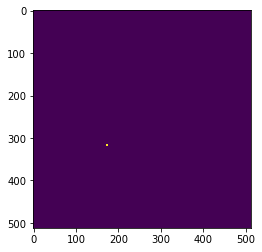

In [275]:
path_bmp = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/processed/subset0/slices/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762_182_lung_img.bmp'
path_lung = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/processed/subset0/slices/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762_182_lung_img.npz.npy'
path_mask = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/processed/subset0/slices/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762_182_nodule_mask.npz.npy'

im = Image.open(path_bmp)
im_lung = np.load(path_lung)
im_mask = np.load(path_mask)
im.show()
plt.imshow(im_mask)

In [141]:
slice_folder = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/processed/subset0/slices'
list_npy = os.listdir(slice_folder)

list_lung = []
list_nodule = []

for i,name in enumerate(list_npy):
    if name[-16:-8] == "lung_img":
        list_lung.append(name)
    elif name[-19:-8] == "nodule_mask":
        list_nodule.append(name)

list_lung.sort()
list_nodule.sort()

print(list_lung[10])
print(list_nodule[10])

1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_78_lung_img.npz.npy
1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_78_nodule_mask.npz.npy


In [261]:
A = os.path.join(slice_folder,list_lung[750])
B = np.load(A)

C = os.path.join(slice_folder,list_nodule[750])
D = np.load(C)

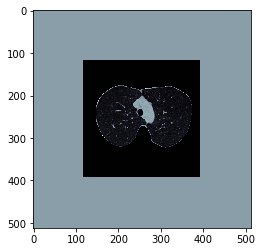

In [262]:
plt.imshow(B,cmap=pylab.cm.bone)

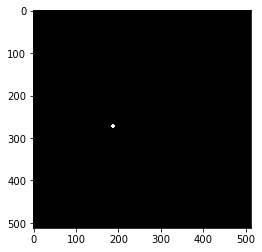

In [263]:
plt.imshow(D,cmap=pylab.cm.bone)

### UNET __ WIP

In [ ]:
# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, Convolution2D, MaxPooling3D, MaxPooling2D
from keras import layers
from keras import Model
from keras.utils import np_utils
from keras import backend as K

In [ ]:
inputs = Input(512,512,1)

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
print "conv1 shape:",conv1.shape
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
print "conv1 shape:",conv1.shape
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print "pool1 shape:",pool1.shape

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
print "conv2 shape:",conv2.shape
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
print "conv2 shape:",conv2.shape
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print "pool2 shape:",pool2.shape

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
print "conv3 shape:",conv3.shape
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
print "conv3 shape:",conv3.shape
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print "pool3 shape:",pool3.shape

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.summary()

In [ ]:
from keras.callbacks import TensorBoard


def generate_unique_logpath(logdir, raw_run_name):
        i = 0
        while(True):
                run_name = raw_run_name + "-" + str(i)
                log_path = os.path.join(logdir, run_name)
                if not os.path.isdir(log_path):
                        return log_path
                i = i + 1
                
run_name = "linear_1"
logpath = generate_unique_logpath("/home/lucsoret/Projet/Iniation_Python/Deep_Learning_With_Python/logs_linear/5_2", run_name)
tbcb = TensorBoard(log_dir=logpath)